In [51]:
%pylab inline
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import planetary_computer
import pystac_client
import pystac
import os
from xradd import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['detrend']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
texas_gdf = gpd.read_file("Texas_State_Boundary/State.shp")

In [59]:
# Read the GeoTIFF file using rasterio
with rasterio.open('gpw_v4_population_density_rev11_2020_15_min.tif') as src:
    data = src.read()
    meta = src.meta

# Create an xarray DataFrame from the data and metadata
data_df = xr.DataArray(data.squeeze(), dims=('lat', 'lon'), coords={'lat': meta['transform'][5] + np.arange(data.shape[1]) * meta['transform'][4],
                                                      'lon': meta['transform'][2] + np.arange(data.shape[2]) * meta['transform'][0]})

# Add CRS attribute to the xarray DataFrame
data_df.attrs['crs'] = meta['crs']
population = data_df.where(data_df > 0, np.nan)

population['lat']=np.round(population.lat,3)
population['lon']=np.round(population.lon,3)

population

<xarray.DataArray (lat: 720, lon: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.0 -89.25 -89.5 -89.75
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
    y        (lat) float64 90.0 89.75 89.5 89.25 ... -89.0 -89.25 -89.5 -89.75
    x        (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    crs:      EPSG:4326

In [54]:
clipped_ds

,Array,Chunk
Bytes,9.83 GiB,3.17 MiB
Shape,"(21, 55115, 43, 53)","(1, 365, 43, 53)"
Count,143 Graph Layers,3171 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,9.83 GiB,3.17 MiB
Shape,"(21, 55115, 43, 53)","(1, 365, 43, 53)"
Count,143 Graph Layers,3171 Chunks
Type,float32,numpy.ndarray


In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

In [4]:
## historical runs
search = catalog.search(
    collections=["cil-gdpcir-cc-by"],
    query={"cmip6:experiment_id": {"eq": "historical"}},
)
items_hist = search.get_all_items()
len(items_hist)

21

In [5]:
## ssp245 runs
search = catalog.search(
    collections=["cil-gdpcir-cc-by"],
    query={"cmip6:experiment_id": {"eq": "ssp245"}},
)
items_ssp = search.get_all_items()
len(items_ssp)

19

In [30]:
scenarios=[]
for items in [items_hist,items_ssp]:
    runs=[]
    for ilist in items:
        item = planetary_computer.sign(ilist)
        mod_output=[xr.open_dataset(item.assets[mm].href,\
                                    **item.assets[mm].extra_fields["xarray:open_kwargs"]) for mm in 'tasmax tasmin'.split()]
        mod_output2=xr.merge(mod_output)
        nm=ilist.to_dict()['properties']['cmip6:source_id']
        mod_output2=mod_output2.assign_coords(model=[nm])
        runs.append(mod_output2)
        print(nm,end=' ')
        # break
    print()
    scenarios.append(xr.concat(runs,dim='model'))
    # break
combined=xr.concat(scenarios,dim='time')

NESM3 GFDL-ESM4 GFDL-CM4 NorESM2-MM NorESM2-LM MPI-ESM1-2-LR MPI-ESM1-2-HR UKESM1-0-LL HadGEM3-GC31-LL MIROC-ES2L MIROC6 EC-Earth3-Veg-LR EC-Earth3-Veg EC-Earth3 EC-Earth3-CC EC-Earth3-AerChem ACCESS-CM2 ACCESS-ESM1-5 CMCC-ESM2 CMCC-CM2-SR5 BCC-CSM2-MR 
NESM3 GFDL-ESM4 GFDL-CM4 NorESM2-MM NorESM2-LM MPI-ESM1-2-LR UKESM1-0-LL HadGEM3-GC31-LL MIROC-ES2L EC-Earth3-Veg EC-Earth3-Veg-LR EC-Earth3 EC-Earth3-CC ACCESS-CM2 ACCESS-ESM1-5 CMCC-ESM2 CMCC-CM2-SR5 BCC-CSM2-MR 


/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4796: PerformanceWarning: Increasing number of chunks by factor of 19
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4796: PerformanceWarning: Increasing number of chunks by factor of 19
  result = blockwise(


In [31]:
# Assuming you have an xarray dataset called 'ds'
# Replace this line with the code to load your dataset
ds = combined
ds = ds.rename({'lon': 'x', 'lat': 'y'})

# Set the CRS (Coordinate Reference System) for the dataset
# ds = ds.rio.set_crs('EPSG:4326')
ds = ds.rio.write_crs("EPSG:4326")

# Clip the dataset to the Texas boundary
clipped_ds = ds.rio.clip(texas_gdf.geometry)

clipped_ds = clipped_ds.rename({'x': 'lon', 'y': 'lat'})

# The 'clipped_ds' variable now contains an xarray dataset with grid points within Texas boundaries

In [60]:
pop1=population.interp(lon=clipped_ds.lon,lat=clipped_ds.lat)

In [33]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()                
pbar.register() # global registration

In [111]:
weights=(pop1*np.cos(np.deg2rad(clipped_ds.lat))).fillna(0)
# weights=(pop1*0+np.cos(np.deg2rad(clipped_ds.lat))).fillna(0)

for ii in clipped_ds.model:
    fn=f'{ii}.nc'
    if os.path.exists(fn): continue
    print(fn)
    
    ## select model
    x1=clipped_ds.sel(model=ii)
    weighted_data = x1.weighted(weights) # create weighted xarray Dataset

    # Calculate the weighted mean along the desired dimensions (e.g., 'lat' and 'lon')
    weighted_mean = weighted_data.mean(dim=['lat', 'lon'])
    weighted_mean.to_netcdf(f'{ii}.nc')

HadGEM3-GC31-LL.nc
[########################################] | 100% Completed | 178.71 s
[########################################] | 100% Completed | 178.81 s
MIROC-ES2L.nc
[########################################] | 100% Completed | 176.48 s
[########################################] | 100% Completed | 176.52 s
MIROC6.nc
[########################################] | 100% Completed | 209.47 s
[########################################] | 100% Completed | 209.53 s
MPI-ESM1-2-HR.nc
[########################################] | 100% Completed | 186.85 s
[########################################] | 100% Completed | 186.94 s
MPI-ESM1-2-LR.nc
[########################################] | 100% Completed | 191.32 s
[########################################] | 100% Completed | 191.41 s
NESM3.nc
[########################################] | 100% Completed | 202.68 s
[########################################] | 100% Completed | 202.70 s
NorESM2-LM.nc
[########################################] | 100

In [114]:
file_paths=glob.glob('*.nc')
model_names=[ii.split('.')[0] for ii in file_paths]

# Read each netCDF file as an xarray Dataset and assign a new 'model' coordinate
datasets = []
for file_path, model_name in zip(file_paths, model_names):
    print(model_name)
    ds = xr.open_dataset(file_path)
    ds = ds.assign_coords(model=model_name)
    datasets.append(ds)

# Concatenate the datasets along the new 'model' dimension
model_temps = xr.concat(datasets, dim="model")

model_temps.to_netcdf('model_temps.nc')

EC-Earth3-Veg
ACCESS-CM2
CMCC-CM2-SR5
EC-Earth3-AerChem
HadGEM3-GC31-LL
MIROC-ES2L
NESM3
BCC-CSM2-MR
MPI-ESM1-2-LR
EC-Earth3-Veg-LR
EC-Earth3
NorESM2-MM
MIROC6
GFDL-ESM4
GFDL-CM4
MPI-ESM1-2-HR
UKESM1-0-LL
ACCESS-ESM1-5
CMCC-ESM2
EC-Earth3-CC
NorESM2-LM


In [119]:
model_temps=xr.open_dataset('model_temps.nc')
model_temps['avg']=(model_temps.tasmax+model_temps.tasmin)/2
model_temps=model_temps.resample(time='A').mean()
model_temps=model_temps - model_temps.sel(time=slice(None,'1980')).mean(dim='time')

/srv/conda/envs/notebook/lib/python3.10/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in true_divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


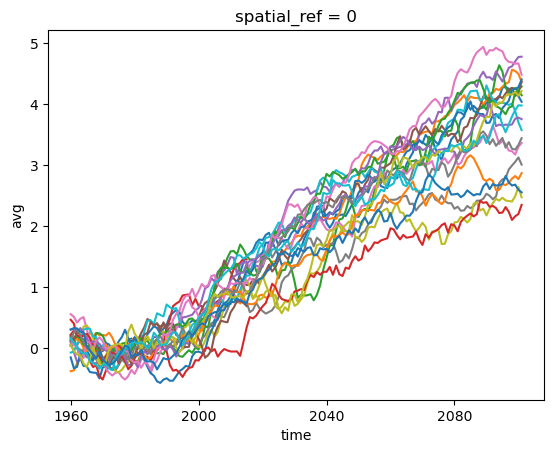

In [120]:
model_temps.avg.rolling(time=10).mean().plot.line(x='time', hue='model',add_legend=False)

In [81]:
encoding = {var: {'zlib': True, 'complevel': 4} for var in x1.data_vars}

# Save the compressed dataset to a new netCDF file
x1.to_netcdf("compressed_dataset.nc", encoding=encoding)

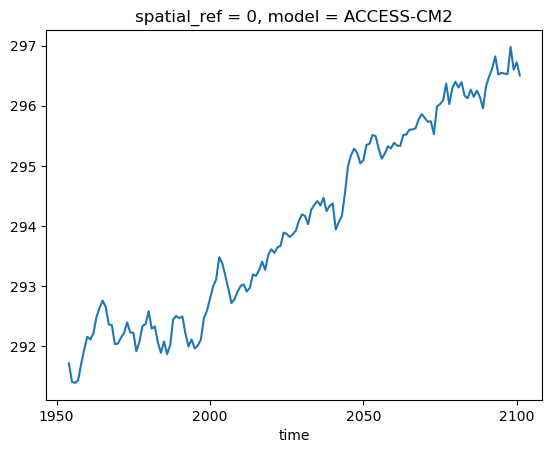

In [89]:
z1.rolling(time=4).mean().plot()

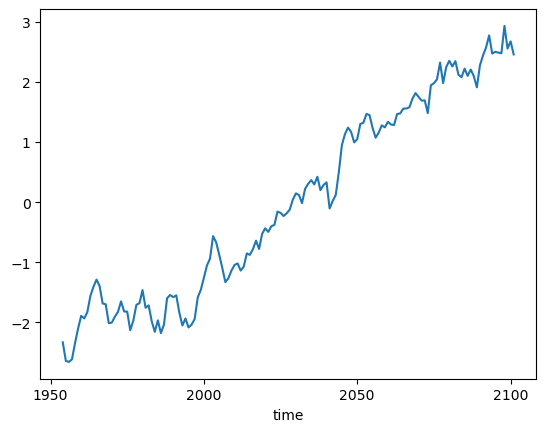

In [76]:
anomaly(z1).rolling(time=4).mean().plot()